<a href="https://colab.research.google.com/github/wisuta/ds_portfolio/blob/main/wongnai_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 😋 Wongnai Review Classification

This notebook is to show how to conduct ML classification model on Thai language using several approaches I learnt from <A HREF="https://colab.research.google.com/github/wisuta/ai_bulider_2022/blob/main/notebooks/04n_NLP_Thai_Text_Classification.ipynb">บทที่ 4n - NLP คืออะไร? บทเรียนจากอดีตสู่ปัจจุบัน</A> provided by AI Builder. 

The step of this notebook is as follows:
1. Notebook Preparation
2. Reading Data
3. Data Exploration
4. Bag of Word
5. RNN/LSTM
6. Pretrained Representation (CNN)  
7. Learning Model: BERT
8. Summary

# 📖 Notebook Preparation

In [ ]:
!pip -q install tensorflow_text
!pip -q install pythainlp==3.0.0
!pip -q install emoji
!pip -q install python-crfsuite
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
# General functions
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.utils import to_categorical

# Huggingfaces
from datasets import load_dataset

# pythainlp
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import process_thai

# 🎈 Reading Data

In [ ]:
# load data from huggingface libary
dataset = load_dataset("wongnai_reviews")

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 6203
    })
})

**Finding:**
- There are total 2 sets provided: train and test set. The size is 40K, 6.2K samples as follows.

In [ ]:
# create to pandas dataframe for data exploration step
# sample train set to 50% for quick model training

# df_train = dataset['train'].to_pandas()
df_train = dataset['train'].to_pandas().groupby('star_rating', group_keys=False).apply(lambda x: x.sample(frac=.5))
df_test = dataset['test'].to_pandas()

print(f"df_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (20001, 2)
df_test shape: (6203, 2)


In [ ]:
# Example of df_train
df_train.head()

,review_body,star_rating
29053,จากร้านอาหารริมทะเล อาหารสด จานโต ราคาสมเหตุผล...,0
13155,รึเพราะลิ้นไม่ถึง จมูกพิการก็ไม่รู้ สั่งชุดขาห...,0
34911,กิน 599 บาท เดือนสองเดือนมากินที เที่ยวนี้วากิ...,0
35914,หน้าร้านตกแต่งสวย แต่พอจะสั่งอาหารเด็กเสริ์ฟทำ...,0
21312,สั่ง ซีซาร์สลัด มีไข่อยู่ครึ่งฟอง มะเขือเทศลูก...,0


In [ ]:
# Example of df_test
df_test.head()

,review_body,star_rating
0,ร้านนี้จะอยู่เส้นสันกำแพง-แม่ออน เลยแยกบ่...,3
1,สั่งไป2 เมนู คือมัชฉะลาเต้ร้อน กับ ไอศครีมชาเข...,2
2,ครัววงเดือน \n\nหิวดึกๆ ตระเวนหาร้านทาน มาเจอ...,2
3,จะว่าเป็นเจ้าประจำก็คงไม่ผิด แต่ก็ไม่กล้า...,3
4,ถ้าคิดถึงสลัดผมคิดถึงร้านนี้เป็นร้านแรกๆเลยครั...,4


# ⚾ Text Processing

In [ ]:
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import process_thai

In [ ]:
text = df_train.review_body.iloc[4]

print(f"original: {text}")
print(f"normalized: {normalize(text)}")
print(f"word_tokenize: {word_tokenize(text)}")
print(f"word_tokenize + normalize: {[normalize(word) for word in word_tokenize(text)]}")
print(f"word_tokenize + normalize + remove stop word: {[normalize(word) for word in word_tokenize(text) if word not in thai_stopwords()]}")
print(f"process_thai: {process_thai(text)}")

original: สั่ง ซีซาร์สลัด มีไข่อยู่ครึ่งฟอง มะเขือเทศลูกเล็กๆ 3ลูก ขนมปังกรอบนิดหน่อย กับเบคอนสีดำคล้ำและเหม็นหืนมาก ส่วนผักก็ไม่ค่อยสดเท่าไหร่ 89บาท

เรื่องบริการ พนักงานยืนกันประมาณ 7คน เต็มเคาน์เตอร์เลย แต่นั่นก็ไม่มีส่วนเกี่ยวข้องกับบริการที่ดี

ไม่แนะนำ*******
normalized: สั่ง ซีซาร์สลัด มีไข่อยู่ครึ่งฟอง มะเขือเทศลูกเล็กๆ 3ลูก ขนมปังกรอบนิดหน่อย กับเบคอนสีดำคล้ำและเหม็นหืนมาก ส่วนผักก็ไม่ค่อยสดเท่าไหร่ 89บาท
เรื่องบริการ พนักงานยืนกันประมาณ 7คน เต็มเคาน์เตอร์เลย แต่นั่นก็ไม่มีส่วนเกี่ยวข้องกับบริการที่ดี
ไม่แนะนำ*******
word_tokenize: ['สั่ง', ' ', 'ซีซาร์', 'สลัด', ' ', 'มี', 'ไข่', 'อยู่', 'ครึ่ง', 'ฟอง', ' ', 'มะเขือเทศ', 'ลูก', 'เล็ก', 'ๆ', ' ', '3', 'ลูก', ' ', 'ขนมปัง', 'กรอบ', 'นิดหน่อย', ' ', 'กับ', 'เบคอน', 'สี', 'ดำคล้ำ', 'และ', 'เหม็นหืน', 'มาก', ' ', 'ส่วน', 'ผัก', 'ก็', 'ไม่ค่อย', 'สด', 'เท่าไหร่', ' ', '89', 'บาท', '\n', '\n', 'เรื่อง', 'บริการ', ' ', 'พนักงาน', 'ยืน', 'กัน', 'ประมาณ', ' ', '7', 'คน', ' ', 'เต็ม', 'เคาน์เตอร์', 'เลย', ' ', 'แต่', 'นั่น', 'ก็', 'ไม่'

**Finding:**  
Choose _processs_thai_ as the function for Thai word tokenization and word normalization. This _process_thai_ includes regular Thai word normalized rule such as remove useless spaces, remove useless newlines, remove special added characters, ungroup emoji, lower case all, and others. It's a good start point for Thai word cleaning and tokenization. Also, we will add remove _thai_stopwords_ also for the effective word tokenize. 



In [ ]:
import re

def process_text(text):
  res = [normalize(word) for word in word_tokenize(text) if (word not in thai_stopwords()) & (word and not re.search(pattern=r"\s+", string=word))]
  return res

process_text("อร่อยยยยยยยยยยมากกกกกกกกกกกกกกกกเลยค่ะ")

['อร่อย', 'ยยยยยยยยย', 'กก', 'กก', 'กก', 'กก', 'กก', 'กก', 'กก', 'กก']

In [ ]:
# create another columns for process_thai including stopword
df_train['processed_review_body'] =  df_train.review_body.apply(lambda x: process_text(x))
df_test['processed_review_body'] = df_test.review_body.apply(lambda x: process_text(x))

# sample data of df_train
df_train.head()

,review_body,star_rating,processed_review_body
29053,จากร้านอาหารริมทะเล อาหารสด จานโต ราคาสมเหตุผล...,0,"[ร้านอาหาร, ริมทะเล, อาหารสด, จาน, ราคา, สม, ก..."
13155,รึเพราะลิ้นไม่ถึง จมูกพิการก็ไม่รู้ สั่งชุดขาห...,0,"[ลิ้น, จมูก, พิการ, รู้, สั่ง, ชุด, ขา, หมู, ส..."
34911,กิน 599 บาท เดือนสองเดือนมากินที เที่ยวนี้วากิ...,0,"[กิน, 599, บาท, เดือน, สอง, เดือน, กิน, เที่ยว..."
35914,หน้าร้านตกแต่งสวย แต่พอจะสั่งอาหารเด็กเสริ์ฟทำ...,0,"[หน้า, ร้าน, ตกแต่ง, สวย, สั่งอาหาร, เด็ก, เส,..."
21312,สั่ง ซีซาร์สลัด มีไข่อยู่ครึ่งฟอง มะเขือเทศลูก...,0,"[สั่ง, ซีซาร์, สลัด, ไข่, ครึ่ง, ฟอง, มะเขือเท..."


# 🚜 Data Exploration  

This part is focus on 

1. Ratio of target both train/test set
3. Word cloud to see the most word usage on train set

## Target Ratio

In [ ]:
# Count star rating on dataset
df_train.star_rating.value_counts()

3    9385
2    6086
4    3400
1     922
0     208
Name: star_rating, dtype: int64

In [ ]:
# Adjust star rating by plus one on all star rating both train and test set

df_train.star_rating = df_train.star_rating+1
df_test.star_rating = df_test.star_rating+1

In [ ]:
# train set target ratio
dct_target_ratio = {
    "cnt_train":df_train.star_rating.value_counts(normalize=False)
    , "pct_train":df_train.star_rating.value_counts(normalize=True)*100
    , "cnt_test":df_test.star_rating.value_counts(normalize=False)
    , "pct_test":df_test.star_rating.value_counts(normalize=True)*100
    }

df_target_ratio = pd.DataFrame(dct_target_ratio).sort_index()
df_target_ratio


,cnt_train,pct_train,cnt_test,pct_test
1,208,1.039948,50,0.806062
2,922,4.609770,206,3.320974
3,6086,30.428479,1906,30.727068
4,9385,46.922654,2977,47.992907
5,3400,16.999150,1064,17.152990


Text(0, 0.5, '%Reviews')

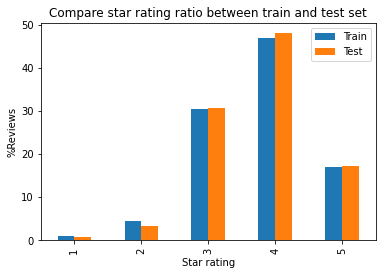

In [ ]:
_=df_target_ratio[['pct_train', 'pct_test']].plot(kind='bar', title="Compare star rating ratio between train and test set")
plt.legend(['Train','Test'])
plt.xlabel("Star rating")
plt.ylabel("%Reviews")

**Finding:**
- The star_rating should be adjusted since the actual score on Wongnai application is from 1-5 stars
- The ratio on both train and test set is quite similar. Around half is on 4 stars (after adjustment) followed by 3 stars (after adjustment)
- Train and test set seem perfectly satisfied the samples. 

## Word cloud

In [ ]:
# ref: https://www.google.com/search?q=thai+word+cloud&rlz=1C1CHBF_enTH769TH770&oq=thai+word+cloud&aqs=chrome..69i57j0i22i30j0i390l4j69i64l2.2553j0j4&sourceid=chrome&ie=UTF-8

from PIL import Image
from wordcloud import WordCloud

In [ ]:
!wget https://www.f0nt.com/download/sipafonts/THSarabunNew.zip; unzip THSarabunNew.zip

--2022-06-20 14:37:37--  https://www.f0nt.com/download/sipafonts/THSarabunNew.zip
Resolving www.f0nt.com (www.f0nt.com)... 103.246.18.21, 2401:5700:100:503::1821
Connecting to www.f0nt.com (www.f0nt.com)|103.246.18.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.f0nt.com/files/sipafonts/THSarabunNew.zip [following]
--2022-06-20 14:37:37--  https://www.f0nt.com/files/sipafonts/THSarabunNew.zip
Reusing existing connection to www.f0nt.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 434047 (424K) [application/zip]
Saving to: ‘THSarabunNew.zip.1’

THSarabunNew.zip.1  100%[===================>] 423.87K  1.27MB/s    in 0.3s    

2022-06-20 14:37:38 (1.27 MB/s) - ‘THSarabunNew.zip.1’ saved [434047/434047]

Archive:  THSarabunNew.zip
replace THSarabunNew Italic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: THSarabunNew Italic.ttf  
  inflating: __MACOSX/._THSarabunNew Italic.ttf  
  inflating: THSarabunNew.ttf        
  i

In [ ]:
def plot_wordclound(text):
  regexp = r"[ก-๙a-zA-Z']+"
  wordcloud = WordCloud(
                        font_path="/content/THSarabunNew.ttf", 
                        relative_scaling = 0.3,
                        min_font_size=1,
                        background_color="white",
                        width=1024,
                        height=768,
                        max_words=2000, 
                        stopwords = thai_stopwords(),
                        # mask=mask,
                        colormap='plasma', 
                        scale=3,
                        font_step=4,
                      #   contour_width=3, 
                      #   contour_color='steelblue', 
                        collocations=False,
                        regexp=regexp,
                        margin=2
                        ).generate(text)

  fig, ax = plt.subplots(1, 1, figsize=(16, 12))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  fig.show()

Text(0.5, 1.0, 'wordcloud for all reviews in training dataset')

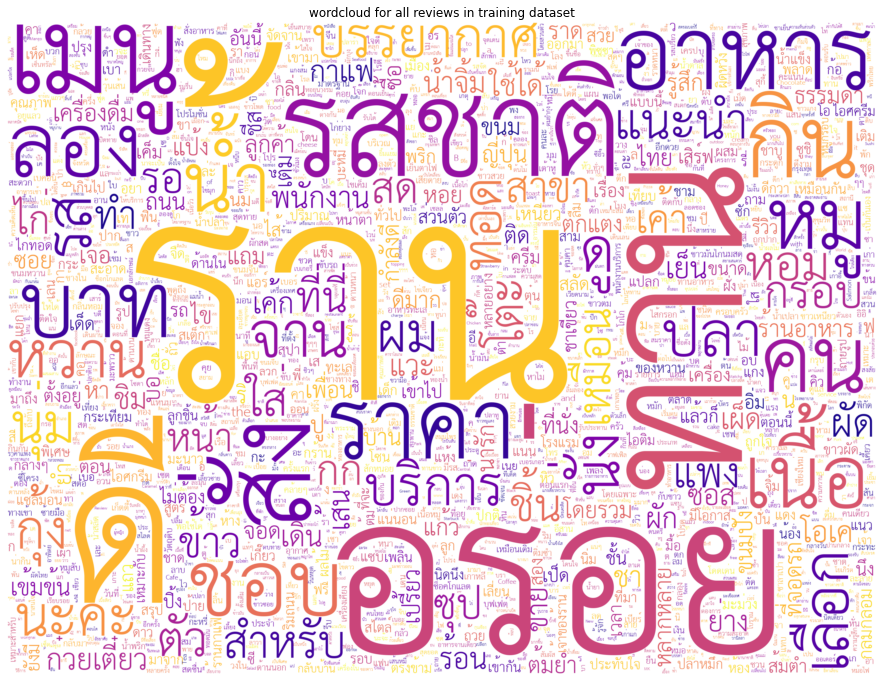

In [ ]:
# text = df_train.review_body[4]
text = " ".join(df_train.processed_review_body.apply(lambda x: " ".join(x)))
plot_wordclound(text)
plt.title("wordcloud for all reviews in training dataset")

Text(0.5, 1.0, 'wordcloud for reviews with star rating = 1 in training dataset')

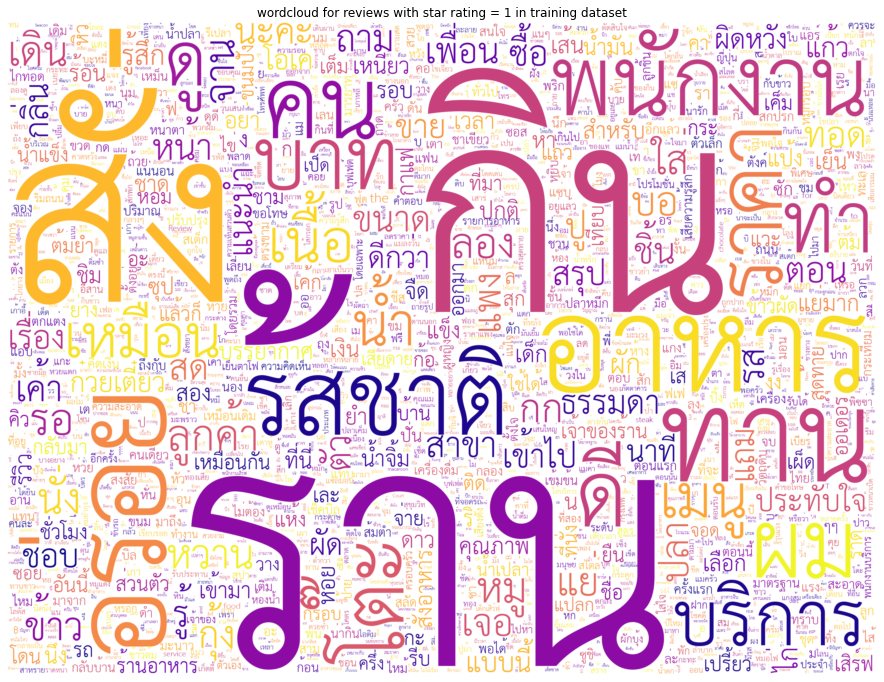

In [ ]:
# star_rating == 1
text = " ".join(df_train.loc[df_train.star_rating==1,"processed_review_body"].apply(lambda x: " ".join(x)))
plot_wordclound(text)

plt.title("wordcloud for reviews with star rating = 1 in training dataset")

Text(0.5, 1.0, 'wordcloud for reviews with star rating = 5 in training dataset')

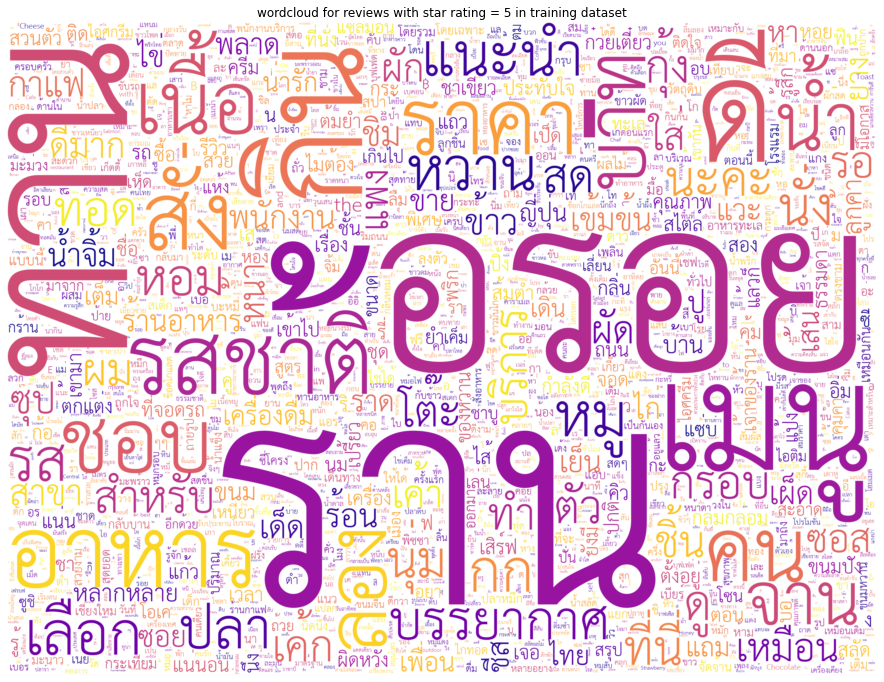

In [ ]:
# star_rating == 5
text = " ".join(df_train.loc[df_train.star_rating==5,"processed_review_body"].apply(lambda x: " ".join(x)))
plot_wordclound(text)

plt.title("wordcloud for reviews with star rating = 5 in training dataset")

# 🖤 Bag of Word

In [ ]:
# Create X, y
X = df_train.review_body
y = df_train.star_rating

# define X_test, y_test
X_test = df_test.review_body
y_test = df_test.star_rating

# Split X,y for train and valid

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# # Create TFIDF Vectorizer and transform predefined X
tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(X_train)
X_train_tfidf = tfidf_fit.transform(X_train)
X_val_tfidf = tfidf_fit.transform(X_val)
X_test_tfidf = tfidf_fit.transform(X_test)

In [ ]:
# See example of TFIDF
i = 10

print(f"original: {X_train[i]}")
print(f"TFIDF: {X_train_tfidf[i]}")
# print(f"Array format: {[np.where(tfidf.get_feature_names_out() == x) for x in train_df['processed'].values.tolist()[0].split('|')[:5]]}")

original: พามาลองอะไรใกล้ๆ บ้านบ้างครับ .. ร้าน "วัวหัวเราะ" เป็นร้านอาหารสไตล์ จิ้มจุ่ม ปิ้งย่าง ฟังจากชื่อร้านแล้วน่าจะพอเดาได้ว่าร้านนี้ "เนื้อ" ต้องเด็ดแน่นอน

ร้านนี้อยู่บริเวณแยกบางพลัดครับ ถ้ามาจากถนนจรัญสนิทวงศ์ (ไม่ว่าจะทางไหนก็ตาม) ให้เลี้ยวเข้าถนนสิริธร (ที่จะมุ่งหน้าไปยังตั้งฮั่วเส็งธนบุรี) ตรงไปไม่กี่ร้อยเมตร บริเวณเชิงสะพานข้ามแยกบางพลัด จะเห็นร้านอยู่ซ้ายมือครับ .. ถ้ามาจากถนนราชวิถี สะพานซังฮี้ ไม่ต้องข้ามสะพานข้ามแยกนะครับ ให้ใช้ทางด้านล่าง ไม่งั้นจะเลยร้านครับ

ร้านนี้จะเปิดช่วงเย็นๆ ไปจนถึงดึกครับ บรรยากาศของร้านก็จะคล้ายๆ กับร้านหมูกระทะทั่วไป เพียงแต่ไม่ใช่บุฟเฟ่ต์ เลยไม่แออัดเท่า โต๊ะจัดวางแบบมีพื้นที่ สบายๆ อากาศถ่ายเทสะดวก ถึงแม้ว่าจะติดถนนก็ไม่มีกลิ่นควันรถมารบกวนแต่อย่างใด (นอกจากคุณจะนั่งโต๊ะใกล้ถนนมากๆ ล่ะก็นะ) .. แสงไฟอาจจะน้อยไปซักนิด ทำให้เวลาย่างเนื้อจะลำบากหน่อยที่ต้องเดาว่า "มันสุกหรือยังเนี่ย ?!?" แต่ก็ไม่ได้ยากมาก ที่สำคัญร้านนี้เปิดเพลงเพราะมากๆ เป็นเพลงฟังสบายๆ สไตล์ Bossa ซึ่งก็งงๆ เหมือนกัน ว่ามันเข้ากับสไตล์ร้านเหรอ 555

อาหารหลักๆ จะมีอยู่ 2 แบ

In [ ]:
# see TFIDF feature name
tfidf.get_feature_names_out()

array(['', ' ', ' (', ..., '⭐️⭐️⭐️ รสชาติ', '⭐️⭐️⭐️⭐️', '⭐️⭐️⭐️⭐️⭐️'],
      dtype=object)

In [ ]:
# model training

model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
model.fit(X_train_tfidf,y_train)
model.score(X_val_tfidf,y_val)

0.5429545454545455

In [ ]:
from sklearn.metrics import classification_report
y_val_pred = model.predict(X_val_tfidf)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           1       0.67      0.03      0.06       139
           2       0.47      0.07      0.12       622
           3       0.53      0.49      0.51      3990
           4       0.56      0.76      0.64      6198
           5       0.47      0.20      0.28      2251

    accuracy                           0.54     13200
   macro avg       0.54      0.31      0.32     13200
weighted avg       0.53      0.54      0.51     13200



In [ ]:
# sample test case

sample = ['ร้านอาหารร้านนี้อร่อยดี','อาหารร้านนี้ไม่อร่อยเลย']
sample_feature = tfidf_fit.transform(sample)
model.predict(sample_feature)

array([4, 5])

# 🖤 RNN/LSTM

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Define y
y = df_train.star_rating
y_test =df_test.star_rating

# Define X
X = df_train.processed_review_body.apply(lambda x: " ".join(x)).values.tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_test = df_test.processed_review_body.apply(lambda x: " ".join(x)).values.tolist()

In [ ]:
print(len(X))
print(len(X_train))

20001
13400


In [ ]:
word_count = []
for sent in X_train:
  for w in sent.split():
      word_count.append(w)

In [ ]:
VOCAB_SIZE = len(set(word_count))
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [ ]:
y_class = [1, 2, 3, 4, 5]

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(y_class)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)

(13400, 5)


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
sample_text = ('ร้านอาหารร้านนี้อร่อยมาก')
predictions = model.predict(np.array([sample_text]))
print(predictions)
le.classes_

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.19889289 0.20102702 0.19723158 0.2009634  0.20188504]]


array([1, 2, 3, 4, 5])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val), epochs=3, verbose=1)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
418/419 [============================>.] - ETA: 0s - loss: 1.2413 - accuracy: 0.4610WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f92b56e9200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

In [ ]:
value = model.predict(np.array(X_val))
y_val_pred = np.argmax(value,axis=1)
y_val_true = np.argmax(y_val,axis=1)
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05        67
           1       0.31      0.27      0.29       291
           2       0.51      0.43      0.47      2007
           3       0.55      0.73      0.63      3161
           4       0.42      0.19      0.26      1075

    accuracy                           0.52      6601
   macro avg       0.41      0.33      0.34      6601
weighted avg       0.51      0.52      0.50      6601



# 🖤 Pretrained Representation (CNN)

In [ ]:

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [ ]:
# Define train/val
train, val = train_test_split(df_train, test_size=0.2)

# Define y
y_train = train.star_rating
y_test =df_test.star_rating
y_val = val.star_rating


# Define X
X_trains = []
X_vals = []
bs = 10

for i in tqdm_notebook(range(y_val.shape[0]//bs+1)):
    X_vals.append(enc(val.review_body[(i*bs):((i+1)*bs)]).numpy())

for i in tqdm_notebook(range(y_train.shape[0]//bs+1)):
    X_trains.append(enc(train.review_body[(i*bs):((i+1)*bs)]).numpy())


X_val = np.concatenate(X_vals,0)
X_train = np.concatenate(X_trains,0)
X_train.shape, X_val.shape

# train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/401 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1601 [00:00<?, ?it/s]

((16000, 512), (4001, 512))

In [ ]:
from sklearn.svm import LinearSVC

text_clf = LinearSVC(class_weight='balanced')
text_clf.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [ ]:
y_val_pred = text_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.11      0.45      0.17        44
           1       0.15      0.34      0.21       192
           2       0.47      0.40      0.43      1219
           3       0.56      0.49      0.52      1856
           4       0.34      0.36      0.35       690

    accuracy                           0.43      4001
   macro avg       0.33      0.41      0.34      4001
weighted avg       0.47      0.43      0.44      4001



# 🖤 Learning Model: BERT

In [ ]:
!pip -q install thai2transformers==0.1.1
!pip install torch==1.7.0

     |████████████████████████████████| 1.3 MB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.3 MB/s 
     |████████████████████████████████| 8.7 MB 8.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 585 kB 63.4 MB/s 
     |████████████████████████████████| 473 kB 72.5 MB/s 
     |████████████████████████████████| 2.9 MB 55.3 MB/s 
     |████████████████████████████████| 87 kB 8.1 MB/s 
     |████████████████████████████████| 880 kB 67.2 MB/s 
     |████████████████████████████████| 419 kB 48.9 MB/s 
     |████████████████████████████████| 106 kB 47.3 MB/s 
     |████████████████████████████████| 123 kB 76.9 MB/s 
     |████████████████████████████████| 15.7 MB 51.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.17 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3

In [ ]:
import pandas as pd
from datasets import load_dataset, load_metric

import torch
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer
)
from thai2transformers.metrics import classification_metrics

In [ ]:
#parameters
class Args:
    model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
    dataset_name_or_path = 'wongnai_reviews'
    feature_col = 'review_body'
    label_col = 'star_rating'
    output_dir = 'models_wongnai/wangchanberta-base-att-spm-uncased_wongnai'
    batch_size = 16
    warmup_percent = 0.1
    learning_rate = 3e-05
    num_train_epochs = 1
    weight_decay = 0.01
    metric_for_best_model = 'f1_micro'
    seed = 1412

args = Args()

In [ ]:
dataset = load_dataset(args.dataset_name_or_path)
dataset = dataset.map(lambda examples: {'labels': examples[args.label_col]}, batched=True)
num_labels = len(set(dataset['train']['labels']))
dataset

Using custom data configuration default
Reusing dataset wongnai_reviews (/root/.cache/huggingface/datasets/wongnai_reviews/default/1.0.1/0741f812b51dea635d957a5cc8f46fcc98828c0f6c557336ab20367778299a4d)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating', 'labels'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating', 'labels'],
        num_rows: 6203
    })
})

In [ ]:
#create tokenizer
tokenizer = AutoTokenizer.from_pretrained(args.model_name, model_max_length=416)

#encode dataset
def encode_function(examples):
    return tokenizer(examples[args.feature_col], truncation=True)
encoded_dataset = dataset.map(encode_function, batched=True)

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
#create model
model = AutoModelForSequenceClassification.from_pretrained(args.model_name, num_labels=num_labels)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [ ]:
train_args = TrainingArguments(
    output_dir = args.output_dir,
    evaluation_strategy = "epoch",
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.batch_size,
    num_train_epochs=args.num_train_epochs,
    warmup_steps = int(len(encoded_dataset['train']) * args.num_train_epochs // args.batch_size * args.warmup_percent),
    weight_decay=args.weight_decay,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=args.metric_for_best_model,
    seed = args.seed
)

In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=classification_metrics
)

In [ ]:
import pandas as pd

In [ ]:
preds  = trainer.predict(encoded_dataset['test'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

,eval_loss,eval_accuracy,eval_f1_micro,eval_precision_micro,eval_recall_micro,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_nb_samples
0,1.570988,0.281799,0.281799,0.281799,0.281799,0.195464,0.213695,0.212555,6203.0


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,Nb Samples
1,0.906074,0.872649,0.615509,0.615509,0.615509,0.615509,0.495119,0.561767,0.472082,6203


TrainOutput(global_step=2500, training_loss=0.99000791015625)

In [ ]:
preds  = trainer.predict(encoded_dataset['test'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

,eval_loss,eval_accuracy,eval_f1_micro,eval_precision_micro,eval_recall_micro,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_nb_samples
0,0.872649,0.615509,0.615509,0.615509,0.615509,0.495119,0.561767,0.472082,6203.0


# ⭐ Summary